In [19]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


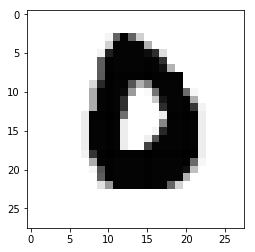

In [20]:
sample_image =mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28,28])
plt.imshow(sample_image, cmap='Greys')

In [21]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [22]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [23]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [24]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

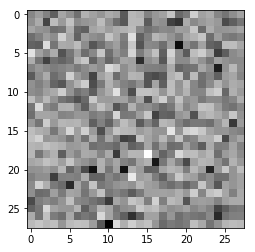

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [26]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [27]:
#discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

In [28]:
#generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

In [29]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


In [30]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [31]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.692958 dLossFake: 0.7080399
dLossReal: 0.009659961 dLossFake: 0.038910426
dLossReal: 0.0018768805 dLossFake: 0.002906063
Iteration: 0 at 2019-06-09 15:50:59.904290


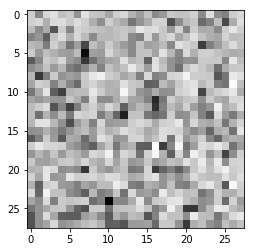

Estimate: [[-7.3290763]]
Iteration: 100 at 2019-06-09 15:54:19.340281


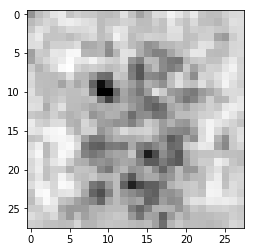

Estimate: [[-6.7666354]]
Iteration: 200 at 2019-06-09 15:57:37.980550


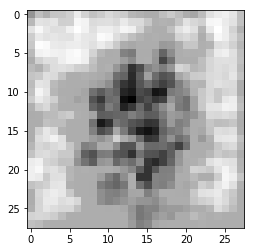

Estimate: [[-6.250674]]
Iteration: 300 at 2019-06-09 16:00:56.618252


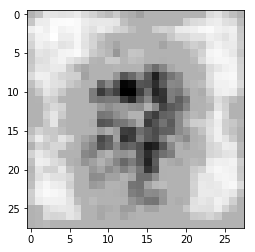

Estimate: [[-7.129614]]
Iteration: 400 at 2019-06-09 16:04:14.088690


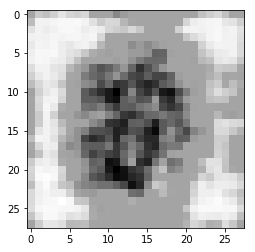

Estimate: [[-7.0716524]]
Iteration: 500 at 2019-06-09 16:07:32.165264


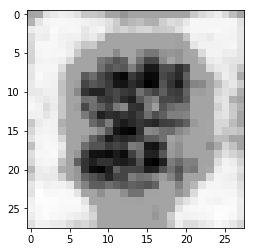

Estimate: [[-6.8235726]]
Iteration: 600 at 2019-06-09 16:10:50.861978


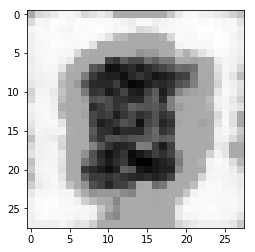

Estimate: [[-6.6826344]]
Iteration: 700 at 2019-06-09 16:14:09.435666


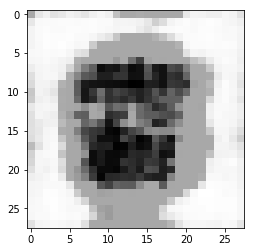

Estimate: [[-7.6741557]]
Iteration: 800 at 2019-06-09 16:17:27.333200


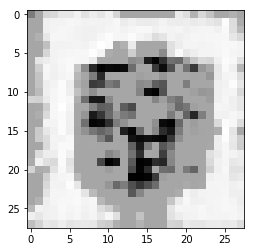

Estimate: [[-6.162704]]
Iteration: 900 at 2019-06-09 16:20:45.541804


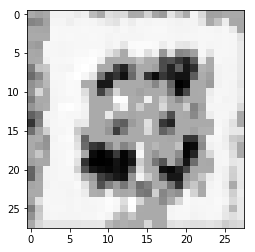

Estimate: [[-5.4468293]]
Iteration: 1000 at 2019-06-09 16:24:03.315310


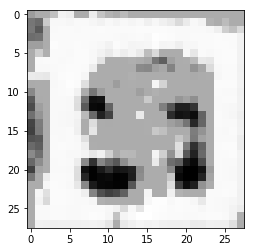

Estimate: [[-5.21717]]
Iteration: 1100 at 2019-06-09 16:27:21.418893


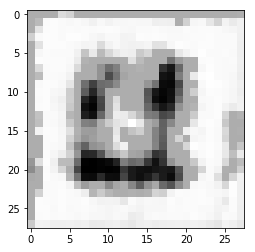

Estimate: [[-4.9559994]]
Iteration: 1200 at 2019-06-09 16:30:39.410194


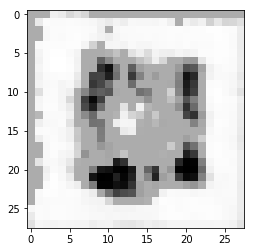

Estimate: [[-12.438454]]
Iteration: 1300 at 2019-06-09 16:33:57.601794


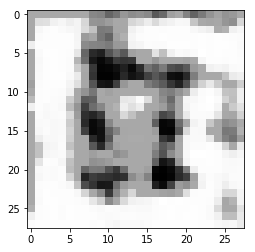

Estimate: [[-7.398247]]
Iteration: 1400 at 2019-06-09 16:37:14.825177


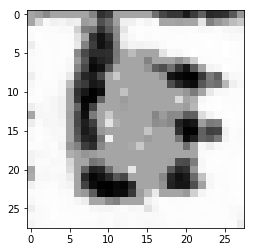

Estimate: [[-7.882135]]
Iteration: 1500 at 2019-06-09 16:40:32.547672


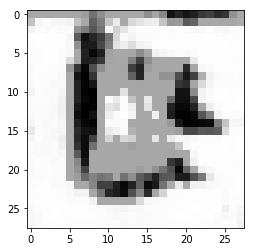

Estimate: [[-7.4985313]]
Iteration: 1600 at 2019-06-09 16:43:50.176601


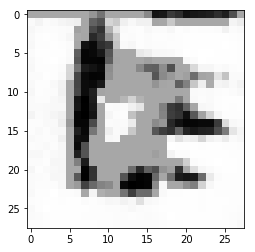

Estimate: [[-7.563107]]
Iteration: 1700 at 2019-06-09 16:47:08.340196


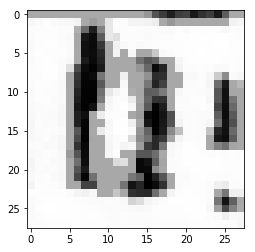

Estimate: [[-5.196567]]
Iteration: 1800 at 2019-06-09 16:50:26.194720


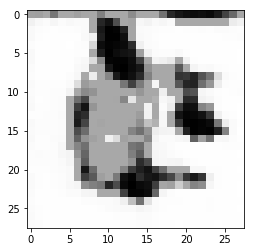

Estimate: [[-5.933878]]
Iteration: 1900 at 2019-06-09 16:53:43.757179


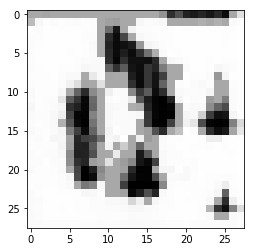

Estimate: [[-15.7742405]]
Iteration: 2000 at 2019-06-09 16:57:01.779742


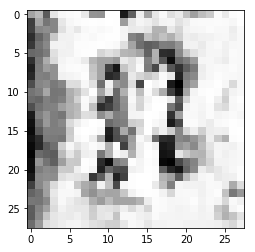

Estimate: [[-4.6682425]]
Iteration: 2100 at 2019-06-09 17:00:20.162385


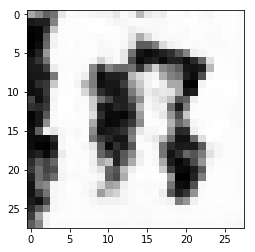

Estimate: [[-8.366101]]
Iteration: 2200 at 2019-06-09 17:03:37.376766


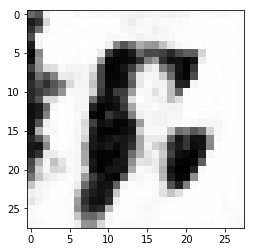

Estimate: [[-7.304946]]
Iteration: 2300 at 2019-06-09 17:06:55.829426


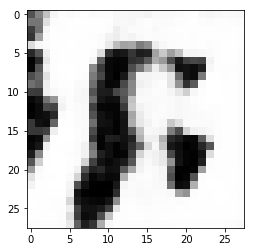

Estimate: [[-5.857234]]
Iteration: 2400 at 2019-06-09 17:10:14.207068


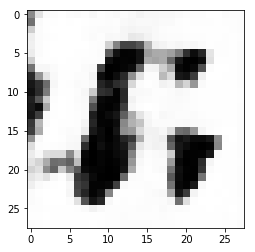

Estimate: [[-6.6047926]]
Iteration: 2500 at 2019-06-09 17:13:31.776529


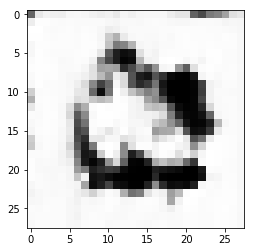

Estimate: [[-24.640865]]
Iteration: 2600 at 2019-06-09 17:16:49.494023


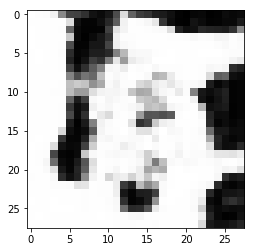

Estimate: [[-3.1646073]]
Iteration: 2700 at 2019-06-09 17:20:07.282533


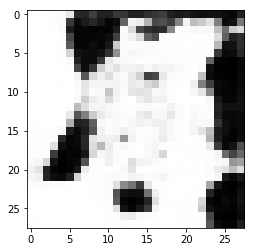

Estimate: [[-5.351835]]
Iteration: 2800 at 2019-06-09 17:23:24.628943


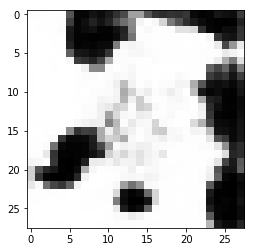

Estimate: [[-8.456458]]
Iteration: 2900 at 2019-06-09 17:26:42.409451


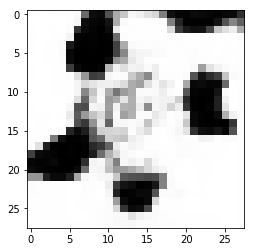

Estimate: [[-8.125661]]
Iteration: 3000 at 2019-06-09 17:30:00.153951


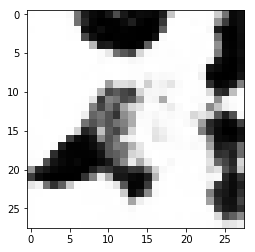

Estimate: [[-8.778885]]
Iteration: 3100 at 2019-06-09 17:33:17.969405


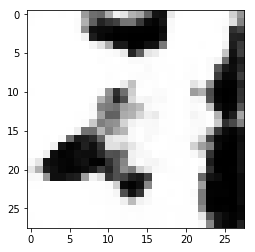

Estimate: [[-7.1744757]]
Iteration: 3200 at 2019-06-09 17:36:36.080988


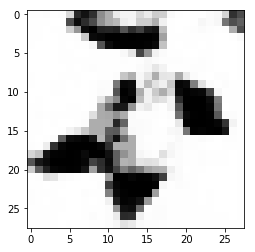

Estimate: [[-12.632042]]
Iteration: 3300 at 2019-06-09 17:39:53.514418


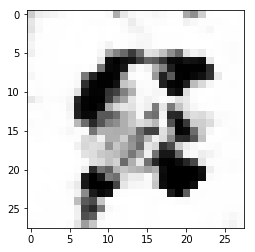

Estimate: [[-32.969296]]
Iteration: 3400 at 2019-06-09 17:43:10.877832


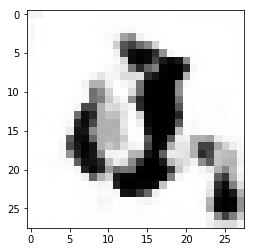

Estimate: [[-15.78947]]
Iteration: 3500 at 2019-06-09 17:46:28.207238


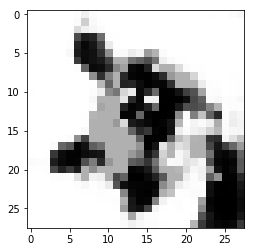

Estimate: [[-25.808327]]
Iteration: 3600 at 2019-06-09 17:49:45.927733


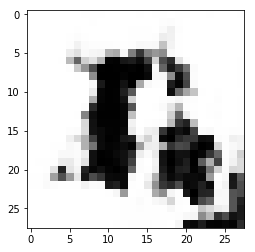

Estimate: [[-93.63448]]
Iteration: 3700 at 2019-06-09 17:53:03.936293


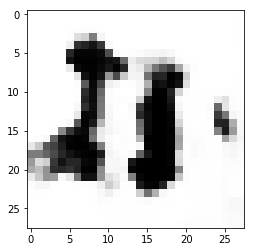

Estimate: [[-67.24313]]
Iteration: 3800 at 2019-06-09 17:56:21.258698


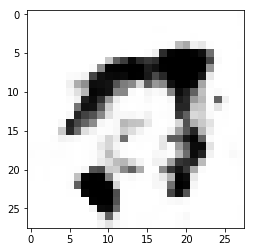

Estimate: [[-26.886446]]
Iteration: 3900 at 2019-06-09 17:59:38.863166


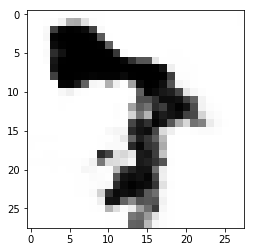

Estimate: [[-67.45608]]
Iteration: 4000 at 2019-06-09 18:02:57.143787


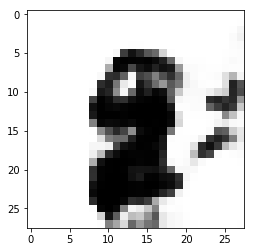

Estimate: [[-45.061726]]
Iteration: 4100 at 2019-06-09 18:06:14.951301


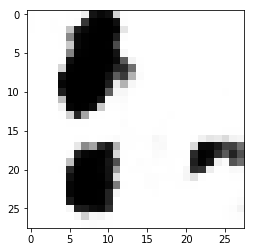

Estimate: [[-55.966103]]
Iteration: 4200 at 2019-06-09 18:09:32.841835


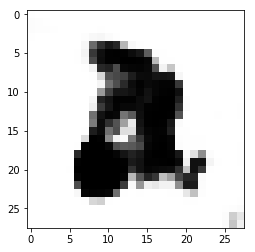

Estimate: [[-30.522217]]
Iteration: 4300 at 2019-06-09 18:12:50.556327


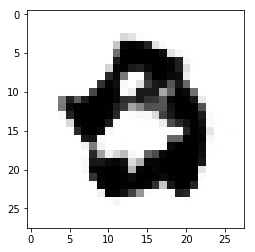

Estimate: [[-21.800503]]
Iteration: 4400 at 2019-06-09 18:16:08.526878


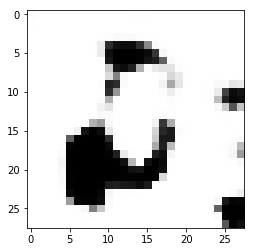

Estimate: [[-33.35883]]
Iteration: 4500 at 2019-06-09 18:19:26.317388


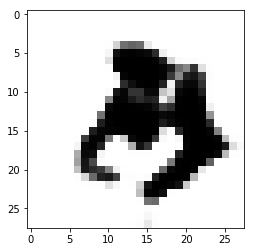

Estimate: [[-21.80242]]
Iteration: 4600 at 2019-06-09 18:22:43.906853


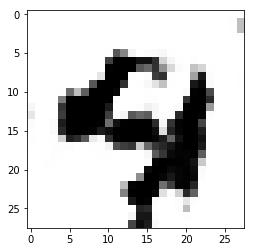

Estimate: [[-9.9993725]]
Iteration: 4700 at 2019-06-09 18:26:01.861401


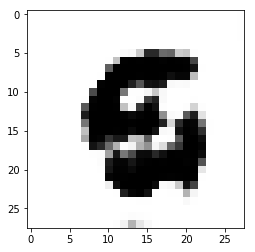

Estimate: [[-20.080143]]
Iteration: 4800 at 2019-06-09 18:29:19.666915


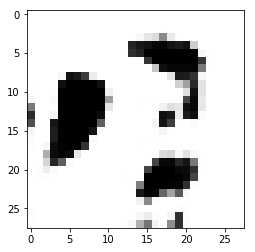

Estimate: [[-23.280678]]
Iteration: 4900 at 2019-06-09 18:32:37.758493


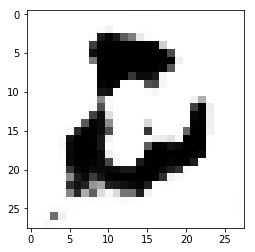

Estimate: [[-17.208115]]
Iteration: 5000 at 2019-06-09 18:35:55.280943


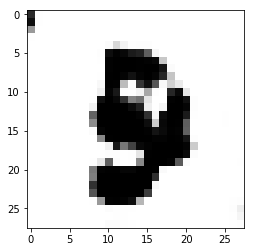

Estimate: [[-11.655651]]
Iteration: 5100 at 2019-06-09 18:39:13.146470


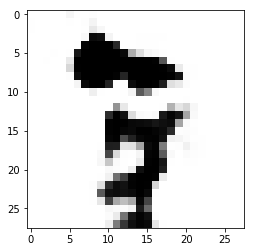

Estimate: [[-13.109524]]
Iteration: 5200 at 2019-06-09 18:42:31.366077


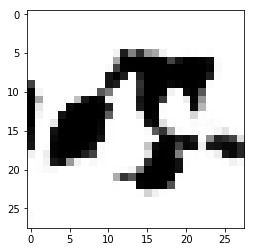

Estimate: [[-16.036606]]
Iteration: 5300 at 2019-06-09 18:45:49.338628


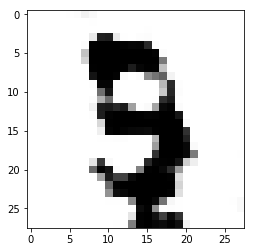

Estimate: [[-9.943058]]
Iteration: 5400 at 2019-06-09 18:49:06.719046


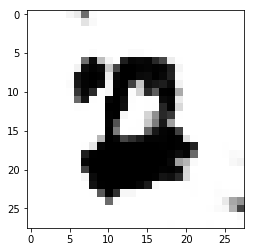

Estimate: [[-20.078056]]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)